In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import keras
from keras.models import *
from keras.layers import *
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_ROOT = './0525'
TRAIN_PATH = os.path.join(DATASET_ROOT, 'taetfp.csv')
AUX_PATH = os.path.join(DATASET_ROOT, 'tasharep.csv')
TS_IN=13
TS_OUT=5
fields = ['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交張數(張)']
fields_dict = dict()
for n, f in enumerate(fields):
    fields_dict[f] = n

In [3]:
train_csv = pd.read_csv(TRAIN_PATH)
train_csv.sort_values(by=['日期', '代碼'], ascending=True, inplace=True)
train_csv[fields] = train_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(train_csv.head(n=10))

aux_csv = pd.read_csv(AUX_PATH)
aux_csv.sort_values(by=['日期', '代碼'], ascending=True, inplace=True) # 照 '日期' 和 '代碼' 排序 (重要)
aux_csv[fields] = aux_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(aux_csv.head(n=10))

,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,50,20130102,元大台灣50,46.57,47.13,46.49,46.92,16487.0
1322,51,20130102,元大中型100,22.36,22.66,22.36,22.65,277.0
2644,52,20130102,富邦科技,26.57,26.95,26.57,26.92,26.0
3966,53,20130102,元大電子,19.84,19.84,19.52,19.81,42.0
5288,54,20130102,元大台商50,16.84,16.84,16.54,16.75,20.0
6610,55,20130102,元大MSCI金融,9.85,9.94,9.83,9.91,2210.0
7932,56,20130102,元大高股息,18.45,18.63,18.45,18.55,1623.0
9254,57,20130102,富邦摩台,30.35,30.69,30.35,30.69,69.0
10576,58,20130102,富邦發達,32.45,32.45,32.12,32.12,2.0
11898,59,20130102,富邦金融,24.65,24.65,24.65,24.65,2.0


C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,1101,20130102,台泥,30.41,30.53,30.18,30.45,6374.0
1322,1102,20130102,亞泥,28.74,28.90,28.70,28.78,2856.0
2644,1103,20130102,嘉泥,12.29,12.33,12.24,12.24,315.0
3966,1104,20130102,環泥,11.87,12.17,11.87,12.06,551.0
5288,1108,20130102,幸福,5.18,5.22,5.16,5.18,447.0
6610,1109,20130102,信大,9.24,9.28,9.19,9.24,104.0
7932,1110,20130102,東泥,13.41,13.46,13.23,13.23,169.0
9254,1201,20130102,味全,35.69,37.74,35.44,37.69,8971.0
10576,1203,20130102,味王,16.61,16.78,16.61,16.73,143.0
11898,1210,20130102,大成,16.84,16.99,16.84,16.87,1373.0


In [4]:
codes = list(sorted(set(train_csv['代碼'])))
aux_codes = np.load('codes_subset.npy') # sorted
days  = list(sorted(set(train_csv['日期']))) # 在 taetfp 內出現的日期才被我們使用
#days_dict = dict()
#for n, day in enumerate(days):
#    days_dict[day] = n

In [5]:
aux_csv = aux_csv.loc[aux_csv['代碼'].isin(aux_codes) & aux_csv['日期'].isin(days)] # 只找在 subset 內的資料

In [6]:
split_days = [] # 同一天分一堆
for day in days:
    row = aux_csv.loc[aux_csv['日期']==day][fields]
    split_days.append(np.asarray(row, dtype=np.float32))
split_days = np.asarray(split_days, dtype=np.float32)

In [7]:
print(split_days.shape) # 先當作日期有對齊好 shape: (1317, 1388, 5) -> 1317 天, 每天有 1388 支股票, 每支股票有 5 個 feature

(1322, 1388, 5)


In [8]:
split_days = split_days.reshape(split_days.shape[0], -1) # shape: (1317, 1388*5=6940) , 攤平
print(split_days.shape)

(1322, 6940)


In [9]:
# Load fitted PCA 
pca_mean = np.load('pca_mean.npy')
pca_components = np.load('pca_components.npy')
print(pca_mean.shape)
print(pca_components.shape)

(6940,)
(60, 6940)


In [10]:
def pca_apply(data_): # data shape: (?, 6940)
    data = data_.transpose((1,0)) # (6940, ?)
    centered_data = data - pca_mean[...,np.newaxis]
    return np.transpose(np.matmul(pca_components, centered_data) ,(1,0)) # (34, 6940) * (6940, ?) = (34, ?) -> (?, 34)

In [11]:
# 套用 PCA (substract mean, pca transform)
split_days_reduced = pca_apply(split_days)
print(split_days_reduced.shape) # (1317, 34)

(1322, 60)


In [12]:
split_train = []
for code in codes:
    row   = np.asarray(train_csv.loc[train_csv['代碼']==code][fields], dtype=np.float32)
    aux_pca_data = split_days_reduced[-row.shape[0]:,:] # 對齊最後幾天 (先當作這樣就對齊了)
    label = np.append(np.array([0], dtype=np.float32), (row[1:,-2] > row[:-1,-2]).astype(np.float32)).astype(np.float32)[...,np.newaxis]
    #row[day-0:, 收盤價] > row[:day-n, 收盤價]
    row = np.concatenate([row, aux_pca_data, label], axis=-1)
    split_train.append(row)

In [13]:
for n, s in enumerate(split_train):
    print(codes[n], s.shape)

50 (1322, 66)
51 (1322, 66)
52 (1322, 66)
53 (1322, 66)
54 (1322, 66)
55 (1322, 66)
56 (1322, 66)
57 (1322, 66)
58 (1322, 66)
59 (1322, 66)
690 (284, 66)
692 (254, 66)
701 (189, 66)
713 (160, 66)
6201 (1322, 66)
6203 (1322, 66)
6204 (1322, 66)
6208 (1322, 66)


In [14]:
from keras.regularizers import *

# custom R2-score metrics for keras backend
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) # mse, model interpretable error
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) # y_true likelyhood variance, not interpretable error
    return (1 - SS_res/(SS_tot + K.epsilon()))
    # if SS_res == SS_tot: at least the model can fit to some extent
    # if SS_res >> SS_tot: the model is lame

def classification_score(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    eq = K.cast(K.equal(K.round(y_true), K.round(y_pred)), 'float32') # shape: batch size, 5, 1 
    return K.mean(K.sum(eq * weights, axis=-2)) # dot_product(eq(batch size, 5, 1), weights(1,5,1)) -> K.mean((batch size, 1)) -> score

def regress_loss(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    wmse = K.mean(K.sum(K.square(y_true-y_pred) * weights, axis=-2)) # mean squared error with weights
    return wmse

def classification_loss(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    wbce = K.mean(K.sum(K.binary_crossentropy(y_true, y_pred) * weights, axis=-2))
    return wbce

def regression_score(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    return K.mean(K.sum((y_true - K.abs(y_pred-y_true)) / (y_true+K.epsilon()) * weights, axis=-2))

def make_model(ts_in=60, ts_out=5, n_field=66, n_encode=128, n_decode=128, reg_a=0.1):
    input_ = Input(shape=(ts_in, n_field))
    noise = GaussianNoise(1e-6) (input_)
    lstm_1 = Bidirectional(CuDNNLSTM(n_encode, return_sequences=False, recurrent_regularizer=l2(reg_a)), merge_mode='sum') (noise)
    rep_vec_2 = RepeatVector(ts_out) (lstm_1)
    lstm_3 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (rep_vec_2)
    lstm_4 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (lstm_3)
    fc_4_regression     = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a)), name='regression') (lstm_4)
    fc_4_classification = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a), activation='sigmoid'), name='class') (lstm_4)
    return Model([input_], [fc_4_regression, fc_4_classification])
make_model(ts_in=TS_IN, ts_out=TS_OUT).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 13, 66)       0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 13, 66)       0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128)          200704      gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 128)       0           bidirectional_1[0][0]            
__________________________________________________________________________________________________
cu_dnnlstm

In [15]:
def make_seq(seq, ts_in=60, ts_out=5):
    Xs = []
    Ys = []
    Ys_label = []
    total_l = ts_in + ts_out
    for i in range(0, len(seq)-total_l+1):
        Xs.append(seq[i:i+ts_in])
        Ys.append(seq[i+ts_in:i+total_l, 3:4])
        Ys_label.append(seq[i+ts_in:i+total_l, -1:]) # 漲跌
    return np.asarray(Xs), np.asarray(Ys), np.asarray(Ys_label)

In [16]:
train_18 = []
for seq in split_train:
    Xs, Ys, Ys_label = make_seq(seq, ts_in=TS_IN, ts_out=TS_OUT)
    train_18.append([Xs, Ys, Ys_label])

In [17]:
from matplotlib.figure import figaspect
def vis(history, title='no title', dpi=80):
    # r2, classification_score, regression_score, lb
    fig_, ax_ = plt.subplots(2, 3, dpi=80, figsize=(20, 5))
    ax = ax_.ravel()
    titles = ['wmse', 'wbce', 'r2', 'classification_score', 'regression_score', 'lb']
    for i, p in enumerate(titles):
        ax[i].set_title(title + ' ' + p + ' plot')
    for i in range(6):
        ax[i].set_xlabel('epoch')
    scores = ['wmse', 'wbce', 'r2', 'acc', 't_brain_regression', 'lb']
    for i, s in enumerate(scores):
        ax[i].set_ylabel(s)
    metric_names = ['regression_loss', 'class_loss', 'regression_r2_keras', 'class_classification_score', 'regression_regression_score']
    locs = [0, 0, 1, 1, 1]
    for i, (name, loc) in enumerate(zip(metric_names, locs)):
        ax[i].plot(history.history[name])
        ax[i].plot(history.history['val_'+name])
        ax[i].legend(['train','valid'], loc='upper right' if loc==0 else 'lower right')
    ax[-1].plot(0.5 * np.asarray(history.history['class_classification_score']) + 0.5 * np.asarray(history.history['regression_regression_score']))
    ax[-1].plot(0.5 * np.asarray(history.history['val_class_classification_score']) + 0.5 * np.asarray(history.history['val_regression_regression_score']))
    ax[-1].legend(['train','valid'], loc='upper right' if loc==0 else 'lower right')
    plt.tight_layout()
    plt.show()

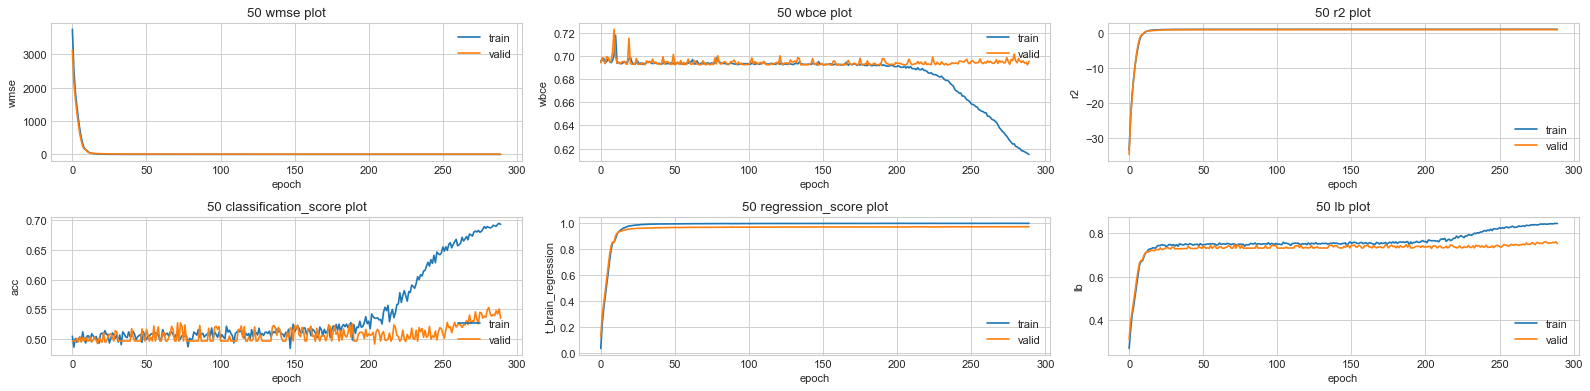

validation wbce: 0.692371
validation wmse: 8.376181
validation r2 : 0.919960
validation acc: 0.550958
validation regression: 0.969730
validation lb: 0.760344


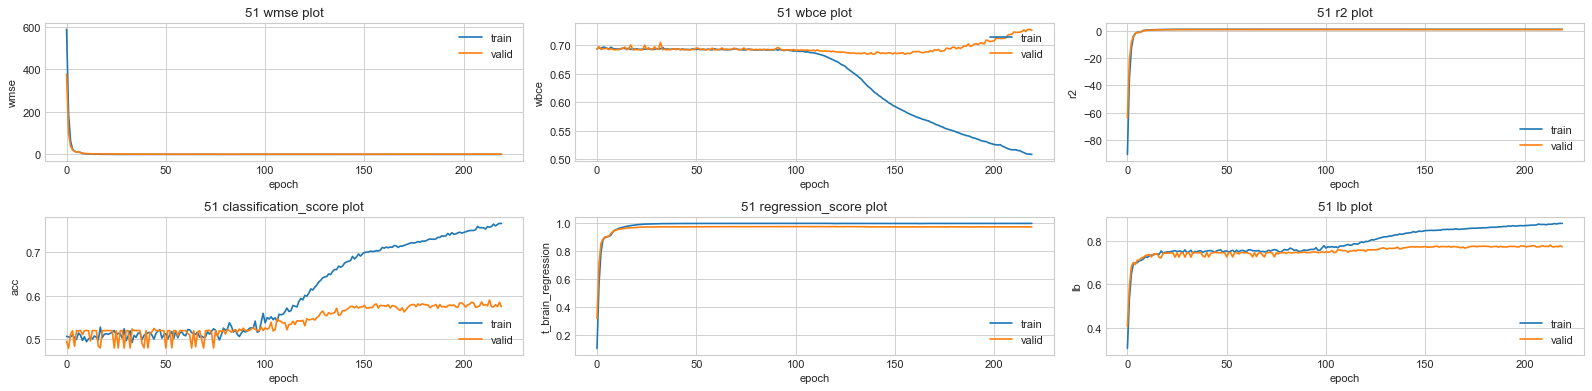

validation wbce: 0.690050
validation wmse: 1.082291
validation r2 : 0.828100
validation acc: 0.543487
validation regression: 0.971391
validation lb: 0.757439


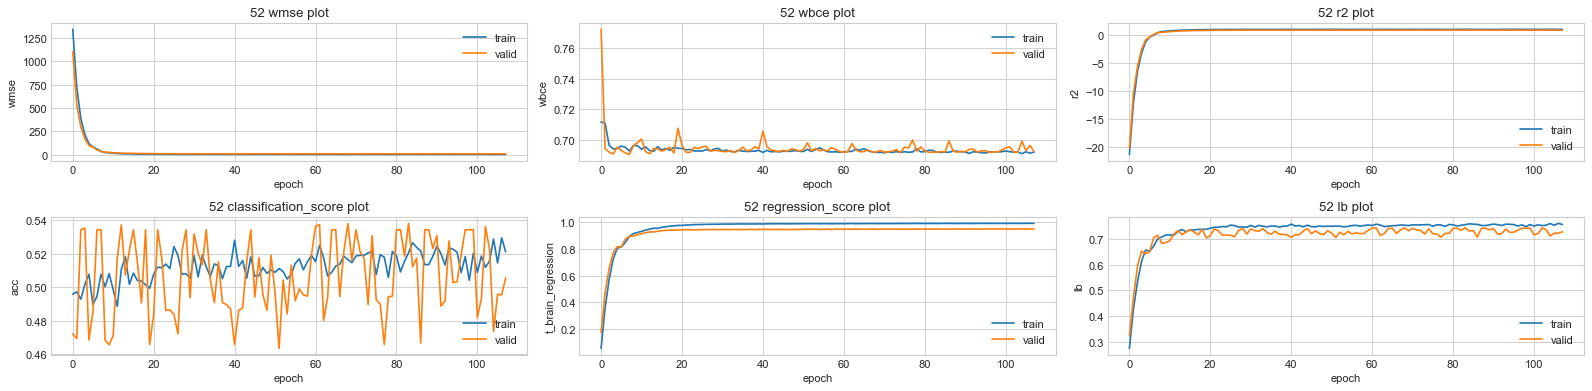

validation wbce: 0.694164
validation wmse: 7.511359
validation r2 : 0.839018
validation acc: 0.491762
validation regression: 0.949634
validation lb: 0.720698


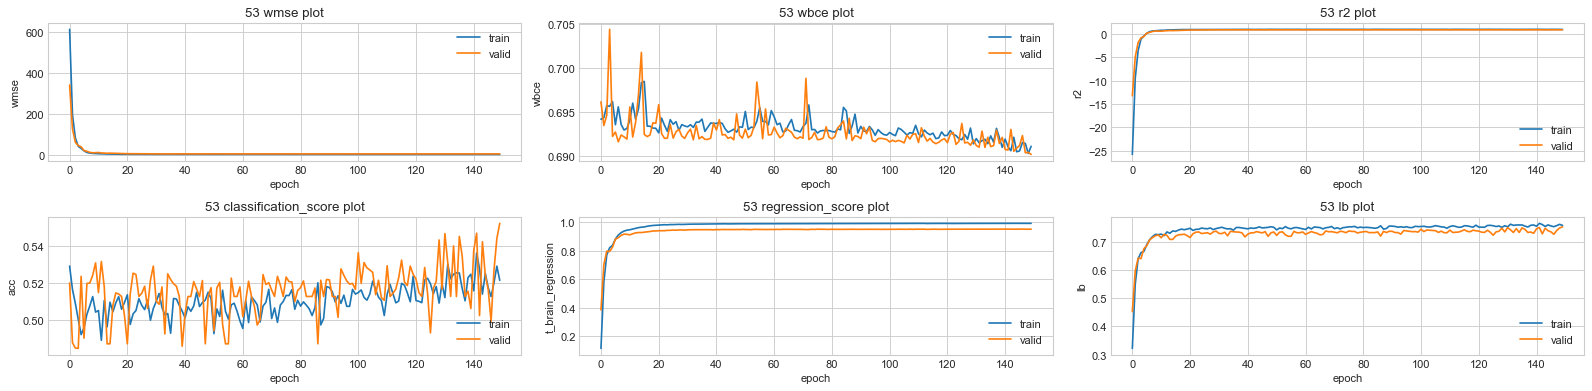

validation wbce: 0.690793
validation wmse: 3.280162
validation r2 : 0.868790
validation acc: 0.537931
validation regression: 0.953204
validation lb: 0.745568


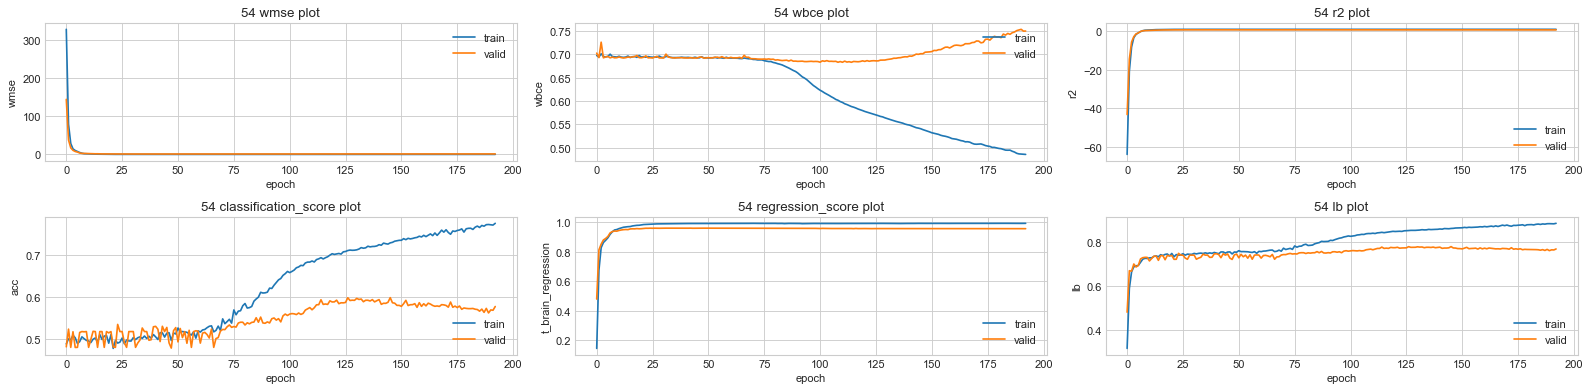

validation wbce: 0.685278
validation wmse: 1.113860
validation r2 : 0.732308
validation acc: 0.548851
validation regression: 0.960716
validation lb: 0.754783


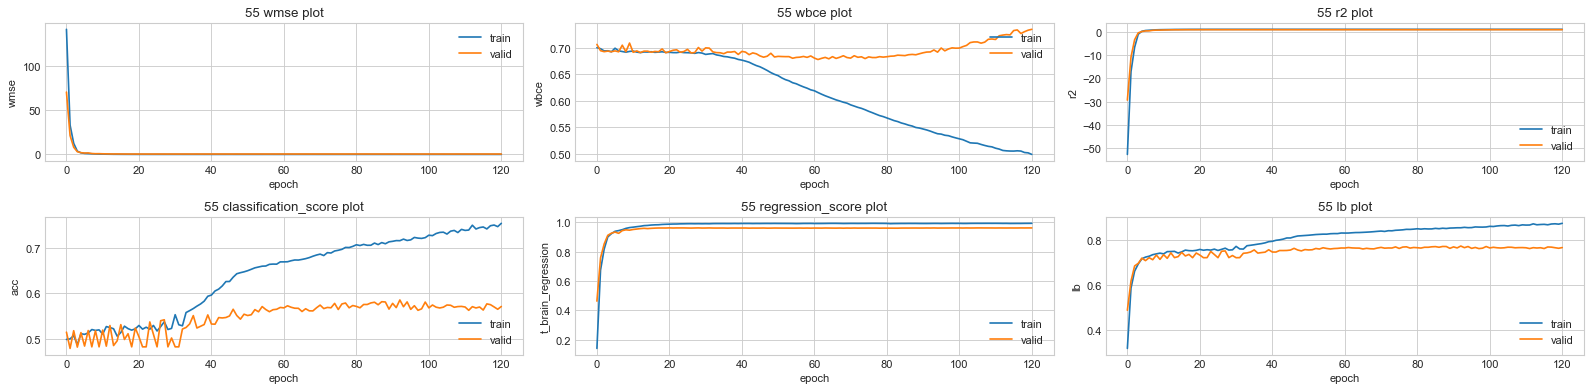

validation wbce: 0.682564
validation wmse: 0.478537
validation r2 : 0.825272
validation acc: 0.565134
validation regression: 0.960794
validation lb: 0.762964


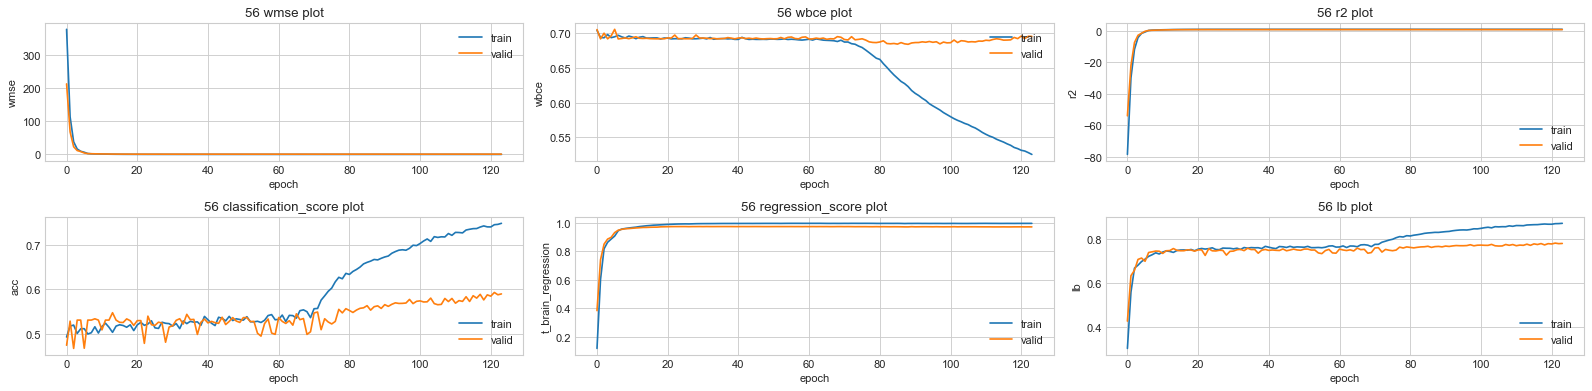

validation wbce: 0.689754
validation wmse: 0.796045
validation r2 : 0.815467
validation acc: 0.549425
validation regression: 0.971875
validation lb: 0.760650


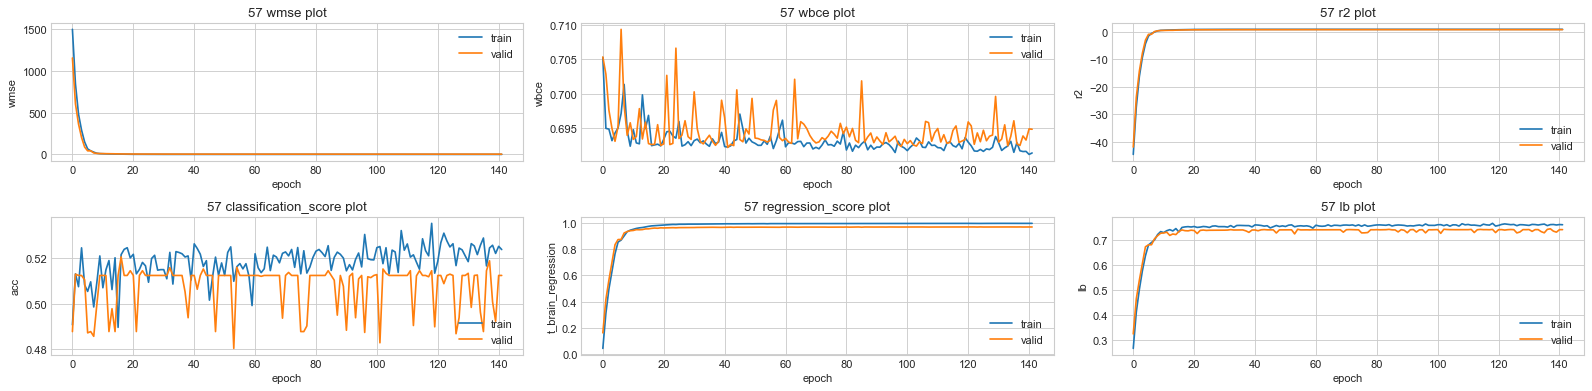

validation wbce: 0.693813
validation wmse: 3.426027
validation r2 : 0.876303
validation acc: 0.496169
validation regression: 0.967041
validation lb: 0.731605


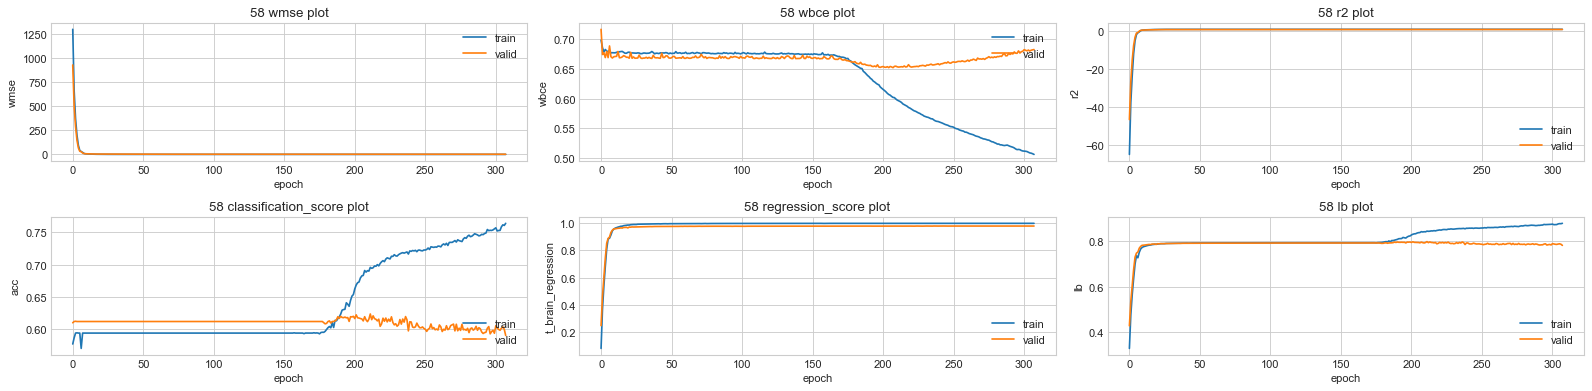

validation wbce: 0.680057
validation wmse: 1.865922
validation r2 : 0.906859
validation acc: 0.601149
validation regression: 0.975750
validation lb: 0.788450


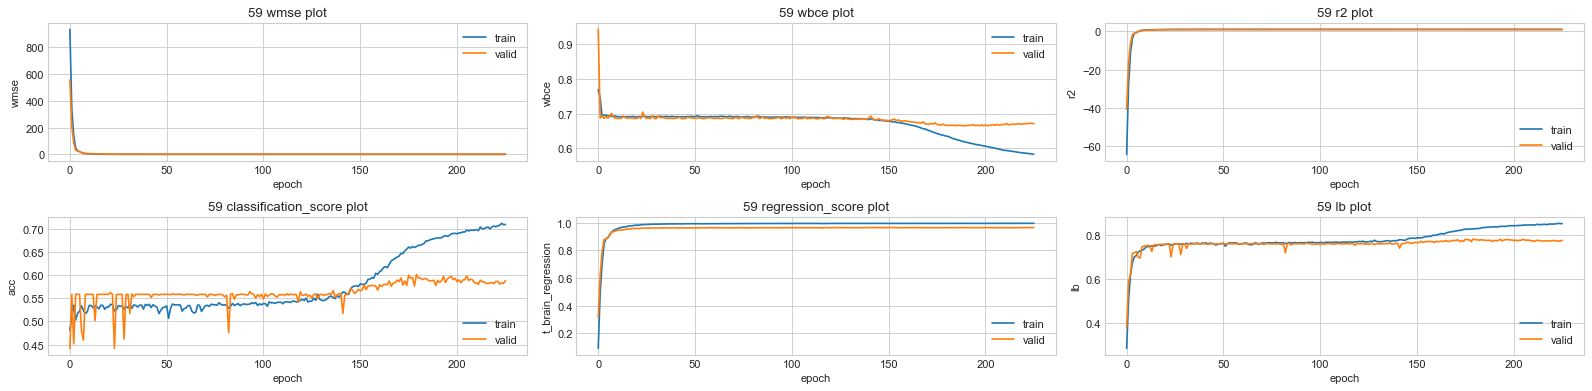

validation wbce: 0.684144
validation wmse: 2.655058
validation r2 : 0.816813
validation acc: 0.568391
validation regression: 0.964089
validation lb: 0.766240


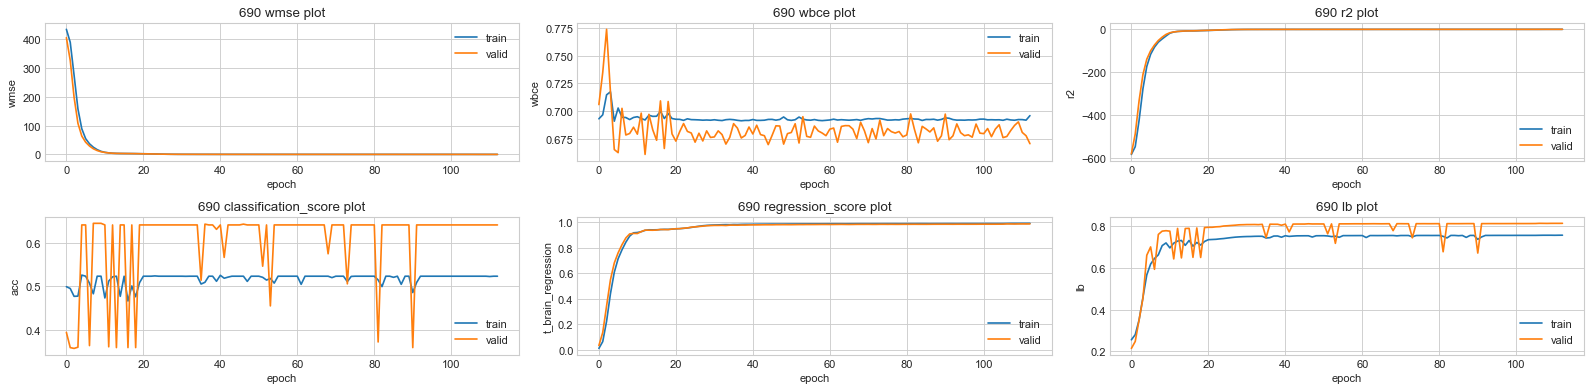

validation wbce: 0.670711
validation wmse: 0.130492
validation r2 : 0.740158
validation acc: 0.641667
validation regression: 0.987169
validation lb: 0.814418


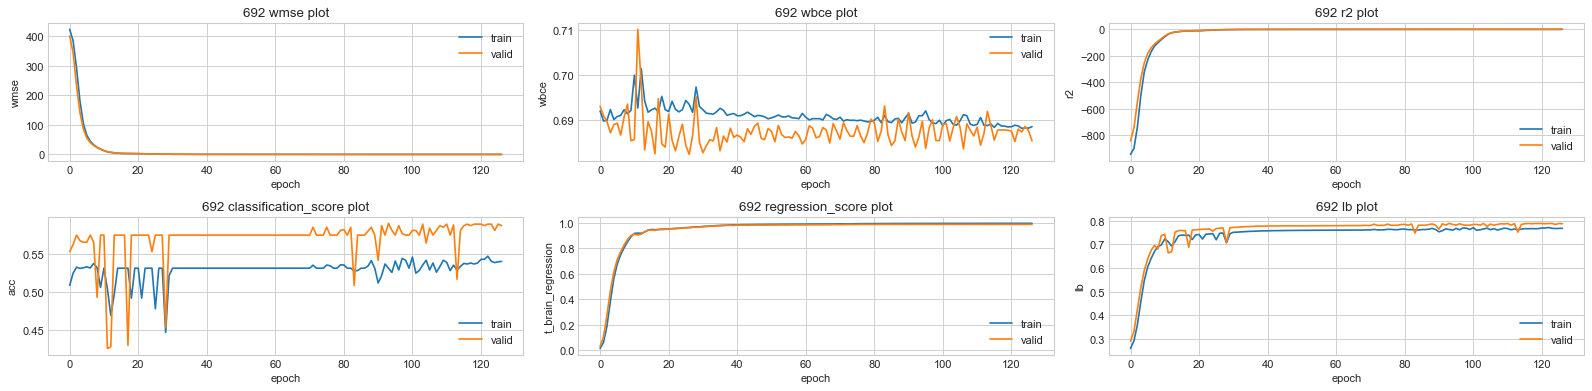

validation wbce: 0.684509
validation wmse: 0.163518
validation r2 : 0.579055
validation acc: 0.575000
validation regression: 0.986623
validation lb: 0.780811


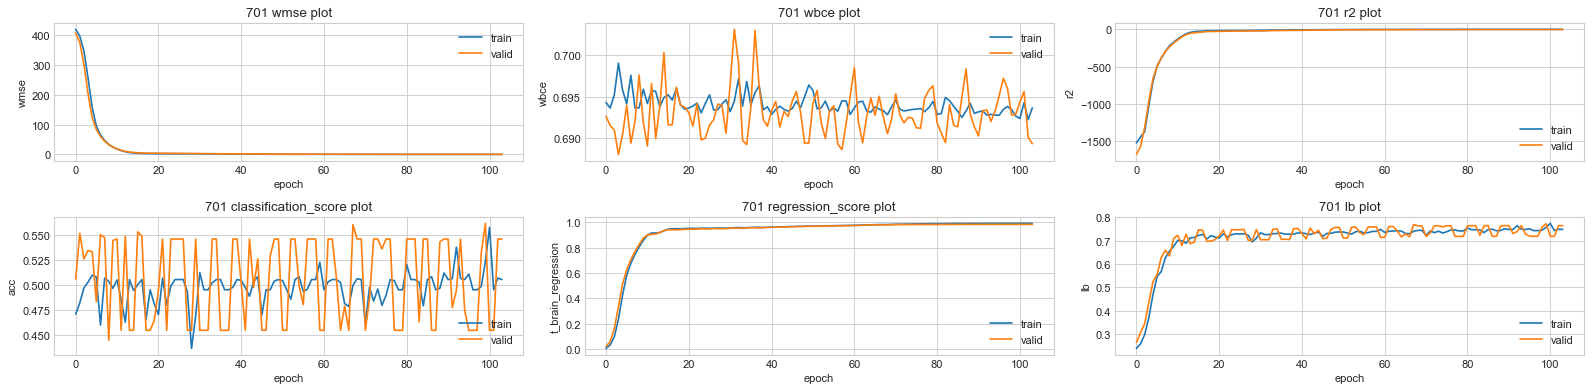

validation wbce: 0.689283
validation wmse: 0.538602
validation r2 : -2.319512
validation acc: 0.545714
validation regression: 0.983907
validation lb: 0.764811


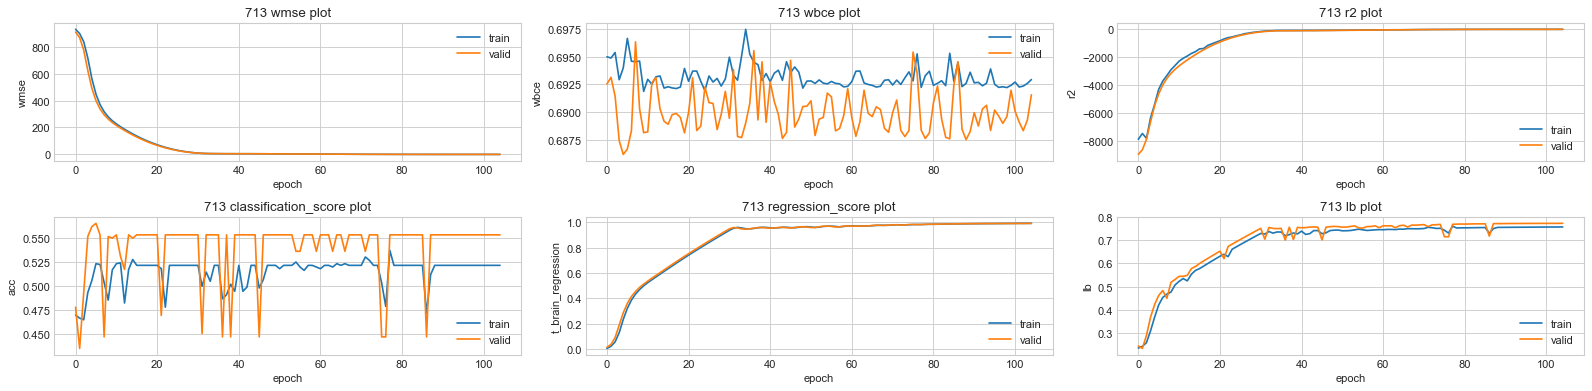

validation wbce: 0.689260
validation wmse: 0.108090
validation r2 : -0.458325
validation acc: 0.553448
validation regression: 0.991720
validation lb: 0.772584


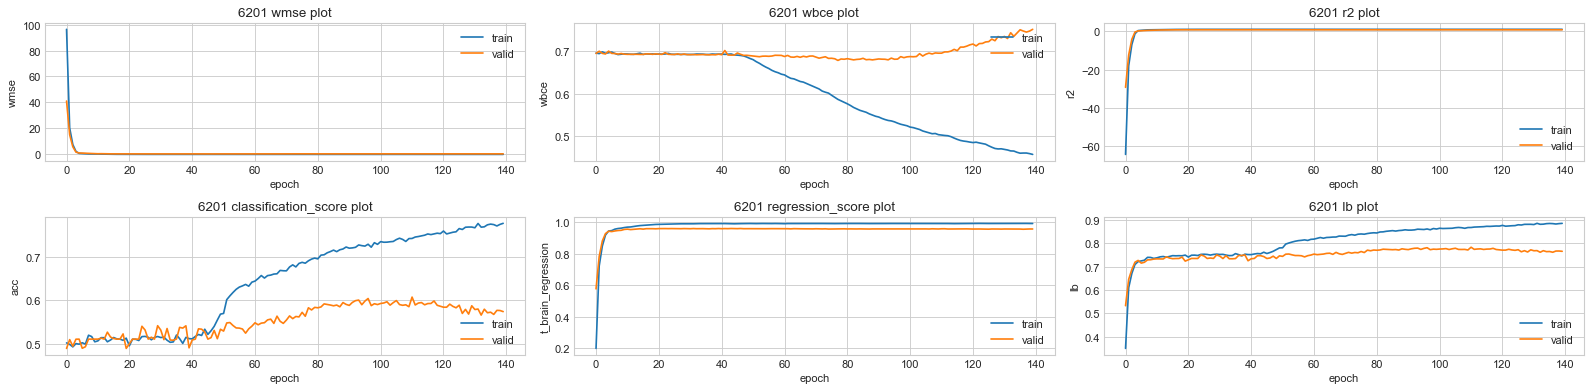

validation wbce: 0.690740
validation wmse: 0.408681
validation r2 : 0.754703
validation acc: 0.533716
validation regression: 0.958917
validation lb: 0.746317


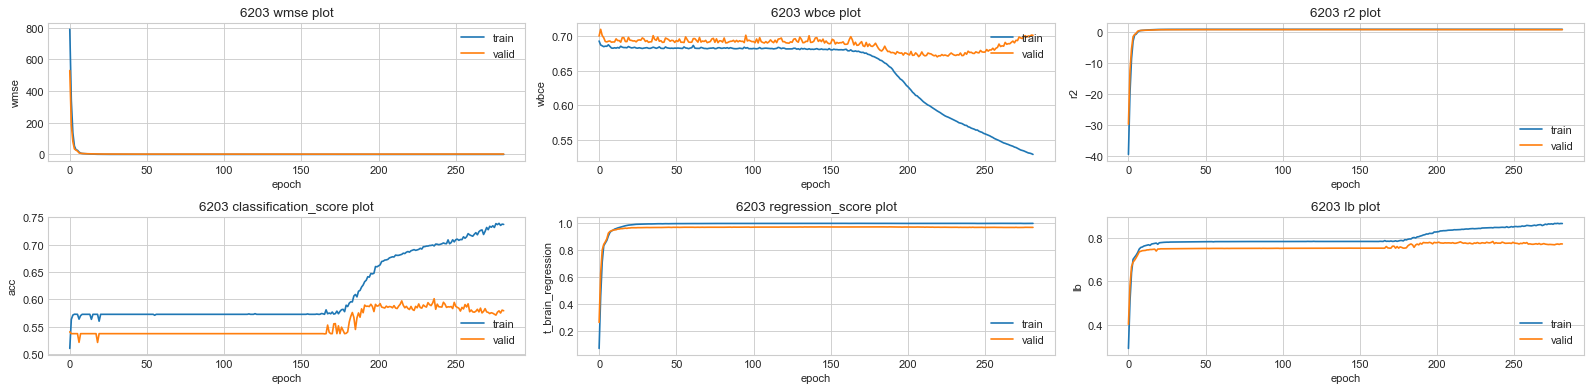

validation wbce: 0.681600
validation wmse: 1.784564
validation r2 : 0.905764
validation acc: 0.558238
validation regression: 0.968835
validation lb: 0.763536


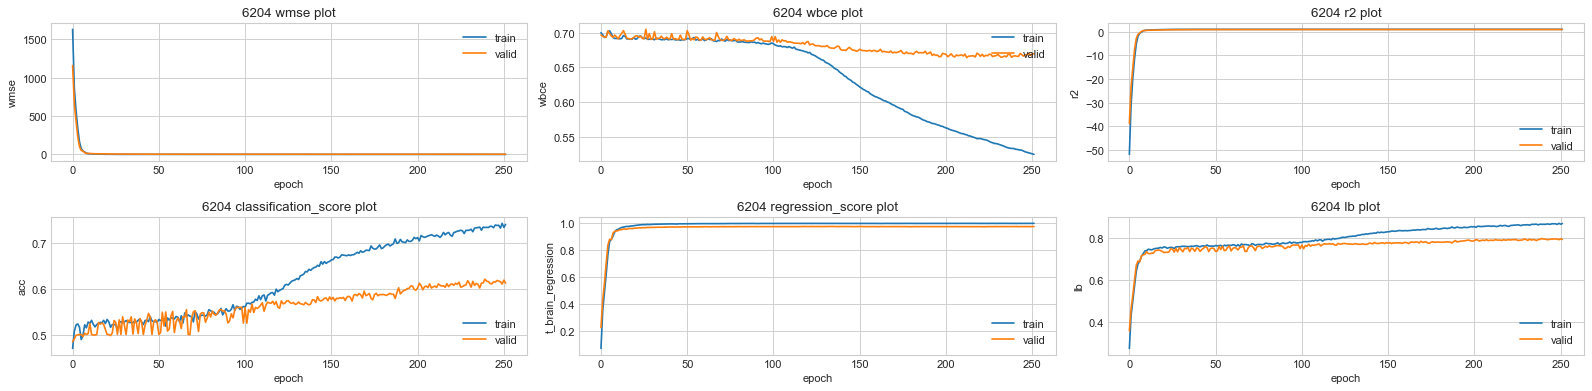

validation wbce: 0.669365
validation wmse: 2.765415
validation r2 : 0.906334
validation acc: 0.619157
validation regression: 0.971768
validation lb: 0.795462


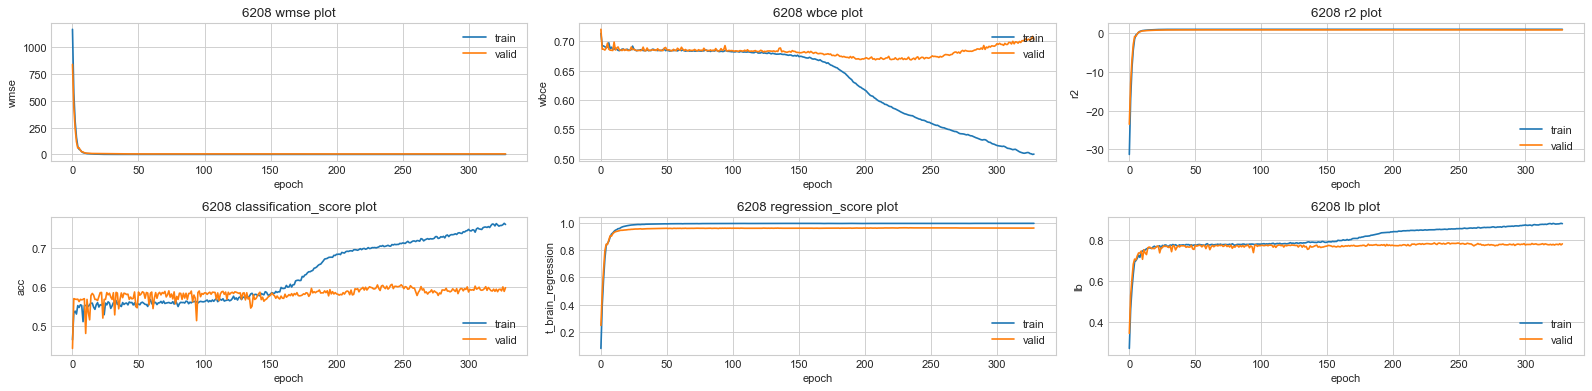

validation wbce: 0.671509
validation wmse: 4.083637
validation r2 : 0.869674
validation acc: 0.595019
validation regression: 0.962081
validation lb: 0.778550


In [18]:
from keras.callbacks import *
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
BATCH_SIZE = 32 # batch size 不要太大, 我們仍然會希望去學習多一點資料中的變異
EPOCH = 800
total_lb = 0
total_vlb = 0
for model_n, (X, Y, label) in enumerate(train_18):
    prefix = str(codes[model_n])
    
    X_train, X_test, Y_train, Y_test, label_train, label_test = train_test_split(X, Y, label, test_size=0.2)
    
    earlystop_class = EarlyStopping(monitor='val_class_loss', patience=100)
    earlystop_reg   = EarlyStopping(monitor='val_regression_loss', patience=100)
    ckpt = ModelCheckpoint(prefix+'_model.h5', save_best_only=True)
    
    model = make_model(ts_in=TS_IN, ts_out=TS_OUT)
    model.compile(loss={'regression':regress_loss, 'class':classification_loss}, optimizer=Adam(clipnorm=1.0), metrics = {'regression':[r2_keras, regression_score], 'class':[classification_score]}, loss_weights={'class':2, 'regression':1})
    history = model.fit(X_train, [Y_train, label_train], validation_data=(X_test, [Y_test, label_test]) , batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=[TensorBoard(log_dir=prefix+'_logs'), earlystop_class, earlystop_reg, ckpt], shuffle=True, verbose=0)
    
    vis(history, title=prefix, dpi=180)
    
    best_e = np.argmin(history.history['val_loss'])
    
    vlb = 0.5*history.history['val_regression_regression_score'][best_e]+0.5*history.history['val_class_classification_score'][best_e]
    print('validation wbce: {:.6f}'.format(history.history['val_class_loss'][best_e]))
    print('validation wmse: {:.6f}'.format(history.history['val_regression_loss'][best_e]))
    print('validation r2 : {:.6f}'.format(history.history['val_regression_r2_keras'][best_e]))
    print('validation acc: {:.6f}'.format(history.history['val_class_classification_score'][best_e]))
    print('validation regression: {:.6f}'.format(history.history['val_regression_regression_score'][best_e]))
    print('validation lb: {:.6f}'.format(vlb))
    
    total_lb += 0.5*history.history['regression_regression_score'][best_e]+0.5*history.history['class_classification_score'][best_e]
    total_vlb += vlb
    
    K.clear_session()

In [19]:
print('Overall training lb: {:.6f}'.format(total_lb))
print('Overall validation lb: {:.6f}'.format(total_vlb))

Overall training lb: 14.248729
Overall validation lb: 13.765230


![](https://tbrain.trendmicro.com.tw/Content/img/18etf.png)

#### Todo:
1. Check missing data / value
2. Do more EDA on dataset
3. Try more baseline models (LSTM, GRU, CNN-1D, XGBoost, SVM, ...) 
4. Add Candlestick chart
5. Add n-fold cross validation
6. 是否天數有對齊?
